# GAN project with İbrahim artworks dataset

In [69]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time
import glob
import imageio
import math
from IPython import display
from PIL import Image

## Helper functions and helper variables

In [70]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# print progress bar
def progress(i, size, status="Progress"):
    progress = i / size * 100
    progress = round(progress, 2)
    print("\r{}: {}%".format(status, progress), end="")

# find number of images in the folder
num_img = len(os.listdir("balaban_resim_cropped"))

## Arguments

### General Arguments

In [71]:
ART_DIR = "balaban_resim_cropped"  # directory of the images
DATA_PATH = "data"  # path to save the dataset
IMG_PATH = "train_images"  # path to save the generated images

GENERATE_RES = 1  # Generation resolution factor (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES  # rows/cols (should be square)

IMAGE_CHANNELS = 3  # number of channels of the images (RGB = 3, Grayscale = 1)

PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

SEED_SIZE = 100

### Image Augmentation Arguments (sample boosting)

In [72]:
SAMPLE_BOOST_SIZE = num_img * 50 # number of samples to boost = 46 * 100 = 4600
ROTATION_RANGE = 15
WIDTH_SHIFT_RANGE = 0.25
HEIGHT_SHIFT_RANGE = 0.25
ZOOM_RANGE = 0.4
HORIZONTAL_FLIP = True
VERTICAL_FLIP = True
FILL_MODE = "reflect"
BRIGHTNESS_RANGE = [0.5, 1.5]
SHEAR_RANGE = 0.05

### Preprocessing Arguments

In [73]:
MEDIAN_FILTER = True

GAUSIAN_FILTER = False

BILITERAL_FILTER = False

### Model Arguments

In [74]:
BATCH_SIZE = 32
EPOCHS = 1000
BUFFER_SIZE = 60000
LR_RATE = 1.5e-6

## Filtering Functions

In [75]:
def median_filter(img):
    return cv2.medianBlur(img, ksize=3)

def gausian_filter(img):
    return cv2.GaussianBlur(img, ksize=(3, 3), sigmaX=0)

def biliteral_filter(img):
    return cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)

## Image loading, preprocessing and image augmentation

In [76]:
if not os.path.exists(IMG_PATH):
    os.makedirs(IMG_PATH)

# if IMG paths has images.npy file, load it

if not os.path.exists(IMG_PATH + "/images.npy"):
    
    for filename in os.listdir(IMG_PATH):
        os.remove(IMG_PATH + "/" + filename)

    images = np.empty((0, GENERATE_SQUARE, GENERATE_SQUARE, IMAGE_CHANNELS))
    for filename in os.listdir(ART_DIR):
        
        img = tf.keras.utils.load_img(ART_DIR + "/" + filename)
        resized_img = img.resize((GENERATE_SQUARE, GENERATE_SQUARE))
        img_array = tf.keras.utils.img_to_array(resized_img)

        if MEDIAN_FILTER:
            img_array = median_filter(img_array)
        elif GAUSIAN_FILTER:
            img_array = gausian_filter(img_array)
        elif BILITERAL_FILTER:
            img_array = biliteral_filter(img_array)

        if img is not None:
            images = np.append(images, [img_array], axis=0)
    

    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=ROTATION_RANGE,
        width_shift_range=WIDTH_SHIFT_RANGE,
        height_shift_range=HEIGHT_SHIFT_RANGE,
        horizontal_flip=HORIZONTAL_FLIP,
        vertical_flip=VERTICAL_FLIP,
        zoom_range=ZOOM_RANGE,
        fill_mode=FILL_MODE,
        brightness_range=BRIGHTNESS_RANGE,
        shear_range=SHEAR_RANGE,
    )


    imageIterator = datagen.flow(np.array(images), batch_size=1)


    for i in range(SAMPLE_BOOST_SIZE):
        aumented_img = imageIterator.next()
        images = np.append(images, aumented_img, axis=0)
        
        progress(i, SAMPLE_BOOST_SIZE, status="Boosting samples")
        

    print("\nNumber of images boosted:", SAMPLE_BOOST_SIZE)
    print("Number of actual images:", num_img)
    print("Number of images loaded:", len(images))
        
    np.save(IMG_PATH + "/images.npy", images)
    print("Images array saved!")

else:
    print("Samples already boosted!")

    images = np.load(IMG_PATH + "/images.npy")
    
    print("Number of images boosted:", SAMPLE_BOOST_SIZE)
    print("Number of actual images:", num_img)
    print("Number of images loaded:", len(images))

Samples already boosted!
Number of images boosted: 2300
Number of actual images: 46
Number of images loaded: 2346


## Creating the training set

In [77]:
training_data = np.array(images).reshape(-1, GENERATE_SQUARE, GENERATE_SQUARE, IMAGE_CHANNELS)
training_data = training_data.astype("float32")
training_data = training_data / 127.5 - 1

training_data = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create generator function

In [78]:
def build_generator(seed_size, channels):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(tf.keras.layers.Reshape((4,4,256)))

    model.add(tf.keras.layers.UpSampling2D())
    model.add(tf.keras.layers.Conv2D(256,kernel_size=3,padding="same"))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Activation("relu"))

    model.add(tf.keras.layers.UpSampling2D())
    model.add(tf.keras.layers.Conv2D(256,kernel_size=3,padding="same"))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(tf.keras.layers.UpSampling2D())
    model.add(tf.keras.layers.Conv2D(128,kernel_size=3,padding="same"))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Activation("relu"))

    if GENERATE_RES>1:
      model.add(tf.keras.layers.UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(tf.keras.layers.Conv2D(128,kernel_size=3,padding="same"))
      model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
      model.add(tf.keras.layers.Activation("relu"))

    # Final CNN layer
    model.add(tf.keras.layers.Conv2D(channels,kernel_size=3,padding="same"))
    model.add(tf.keras.layers.Activation("tanh"))

    return model

### Generator model summary

In [79]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)


generator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 4096)              413696    
                                                                 
 reshape_3 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d_11 (UpSamplin  (None, 8, 8, 256)        0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 8, 8, 256)         590080    
                                                                 
 batch_normalization_47 (Bat  (None, 8, 8, 256)        1024      
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 8, 8, 256)        

### Test generator model

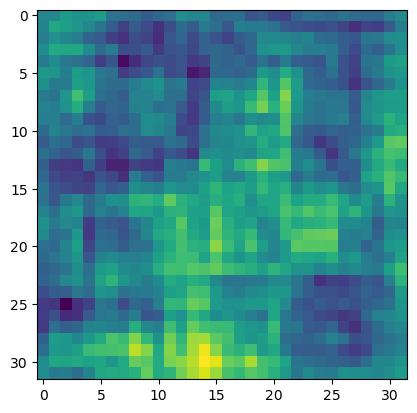

In [80]:
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

## Create discriminator function

In [81]:
def build_discriminator(image_shape):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(tf.keras.layers.ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model

### Summary of discriminator model

In [82]:

image_shape = (GENERATE_SQUARE, GENERATE_SQUARE, IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)

discriminator.summary()



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 16, 16, 32)        896       
                                                                 
 leaky_re_lu_38 (LeakyReLU)  (None, 16, 16, 32)        0         
                                                                 
 conv2d_59 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 zero_padding2d_4 (ZeroPaddi  (None, 9, 9, 64)         0         
 ng2D)                                                           
                                                                 
 batch_normalization_50 (Bat  (None, 9, 9, 64)         256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_39 (LeakyReLU)  (None, 9, 9, 64)         

### Test discriminator model

In [83]:

decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49988165]], shape=(1, 1), dtype=float32)


## Create image save helper function

In [84]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), IMAGE_CHANNELS), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

## Define loss functions

In [85]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Define optimizers

In [86]:
generator_optimizer = tf.keras.optimizers.Adam(LR_RATE,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(LR_RATE,0.5)

## Training step  (Semi-automatic GradientTape)

In [87]:
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

## Training loop

In [88]:
def train(dataset, epochs):
  gen_losses = []
  disc_losses = []
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           f' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

    # add generator loss and discriminator loss to lists
    gen_losses.append(g_loss)
    disc_losses.append(d_loss)


  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

  return gen_losses, disc_losses

## Start training

In [89]:
gen_losses, disc_losses = train(training_data, EPOCHS)

Epoch 1, gen loss=0.8656303882598877,disc loss=1.317534327507019, 0:00:05.25
1/1 [==============================] - 0s 112ms/step
Epoch 2, gen loss=1.169566035270691,disc loss=0.9309693574905396, 0:00:02.22
1/1 [==============================] - 0s 20ms/step
Epoch 3, gen loss=1.364325761795044,disc loss=0.7351148128509521, 0:00:02.23
1/1 [==============================] - 0s 21ms/step
Epoch 4, gen loss=1.471777319908142,disc loss=0.6591827273368835, 0:00:02.26
1/1 [==============================] - 0s 22ms/step
Epoch 5, gen loss=1.6289865970611572,disc loss=0.5622722506523132, 0:00:02.28
1/1 [==============================] - 0s 21ms/step
Epoch 6, gen loss=1.8048793077468872,disc loss=0.4664594233036041, 0:00:02.38
1/1 [==============================] - 0s 21ms/step


KeyboardInterrupt: 

In [ ]:
plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Create GIF for training process

In [ ]:
anim_file = 'dcgan.gif'

images_data = []
for i in range(EPOCHS):
    filename = DATA_PATH+'/output/train-' + str(i) + '.png'
    images_data.append(imageio.imread(filename))
imageio.mimsave(anim_file, images_data, fps=30)

## Display training process

In [ ]:
import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)
